In [1]:
import os, sys
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import pandas as pd
from tqdm import *
import seaborn as sns
from celluloid import Camera

from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.grf import FIRAS

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Where to save plots
plots_dir = "../paper/draft-formalism/plots/"

## Low-$z$ power spectra

In [4]:
# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec = PowerSpectrumGridInterpolator("nonlin_matter")

# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec_lin_matter = PowerSpectrumGridInterpolator("lin_matter")

# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec_franken_lower = PowerSpectrumGridInterpolator("franken_lower")

# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec_franken_upper = PowerSpectrumGridInterpolator("franken_upper")

# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec_lin_baryon = PowerSpectrumGridInterpolator("lin_baryon")

In [5]:
def fix_ticks(ax):
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)

    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.yaxis.set_major_locator(locmaj)

    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


In [6]:
from glob import glob

simulations = ['bahamas', 'eagle', 'illustris', 'tng']
colors =['blue', 'orange', 'red', 'green']

In [7]:
from astropy.cosmology import WMAP9

z, k, Pk, Delta2,  = np.transpose(np.loadtxt("../data/powtable_BAHAMAS_nu0_WMAP9_bar.dat"))
k = k[z==0]
Pk = Pk[z==0] / (WMAP9.Ob0 / WMAP9.Om0) ** 2

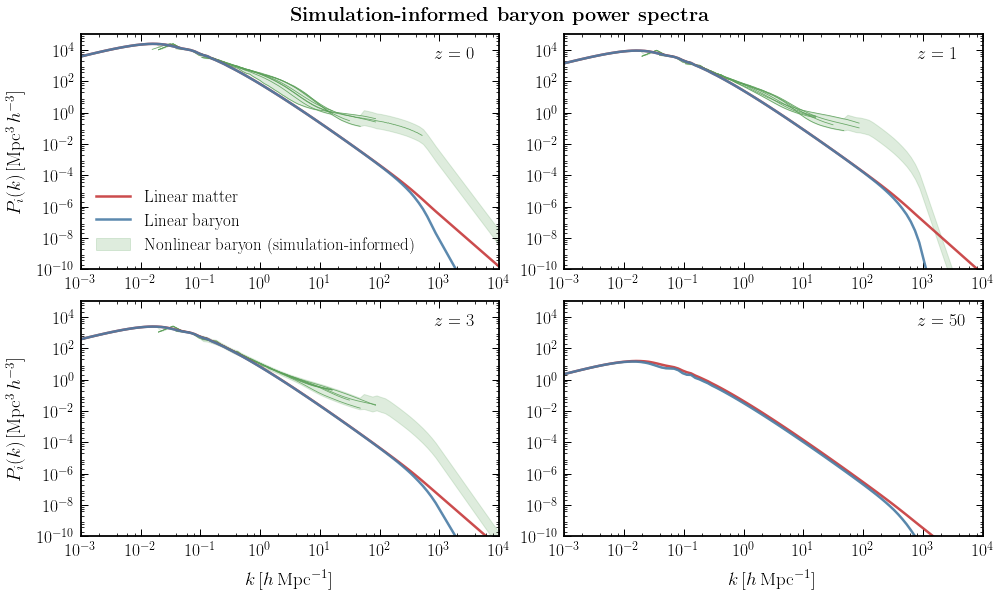

In [10]:
fig, ax = plt.subplots(2,2, figsize=(14 / 1., 8 / 1.))

z_ary = np.array([1e-3, 1, 3, 50])
z_labels_ary = np.array(['0', '1', '3', '50'])
k_ary = np.logspace(-3, 4, 100)

log_pspec_franken_lower_ary = log_pspec_franken_lower(z_ary, k_ary)
log_pspec_franken_upper_ary = log_pspec_franken_upper(z_ary, k_ary)

log_pspec_lin_matter_ary = log_pspec_lin_matter(z_ary, k_ary)
log_pspec_lin_baryon_ary = log_pspec_lin_baryon(z_ary, k_ary)

for i_z in range(len(z_ary)):
    if i_z == 0:
        ax[i_z // 2, i_z % 2].plot(k, Pk, color=cols_default[2], lw=0.8)
        
    if i_z < 3:
        
        for i_simulation, simulation in enumerate(simulations):

            for file1 in glob("../data/hydro_bispectrum/ps/" + simulation + "/*_delta_b_*z" + z_labels_ary[i_z] + "*"):

                if "cross" not in file1:

                    ps_matrix_1 = np.transpose(np.loadtxt(file1))

                    ax[i_z // 2, i_z % 2].plot(ps_matrix_1[0], ps_matrix_1[1], color=cols_default[2], lw=0.8)
 
    ax[i_z // 2, i_z % 2].fill_between(k_ary, 10 ** (log_pspec_franken_lower_ary)[i_z], 10 ** (log_pspec_franken_upper_ary)[i_z], color=cols_default[2], alpha=0.2, label="Nonlinear baryon (simulation-informed)")

    ax[i_z // 2, i_z % 2].plot(k_ary, 10 ** (log_pspec_lin_matter_ary)[i_z], label="Linear matter", color=cols_default[0])
    ax[i_z // 2, i_z % 2].plot(k_ary, 10 ** (log_pspec_lin_baryon_ary)[i_z], label="Linear baryon", color=cols_default[1])

    ax[i_z // 2, i_z % 2].set_xscale("log")
    ax[i_z // 2, i_z % 2].set_yscale("log")
    
    ax[i_z // 2, i_z % 2].set_xlim(min(k_ary), max(k_ary))
    ax[i_z // 2, i_z % 2].set_ylim(1e-10, 1e5)
    
    if i_z // 2 != 0:
        ax[i_z // 2, i_z % 2].set_xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$")

    if i_z % 2 == 0:
        ax[i_z // 2, i_z % 2].set_ylabel("$P_i(k)$\,[Mpc$^3$\,$h^{-3}$]")
    
    fix_ticks(ax[i_z // 2, i_z % 2])
    
    ax[i_z // 2, i_z % 2].text(800, 3e3, r"$z = " + str(z_labels_ary[i_z]) + "$", fontsize=18)
    
    if i_z == 0:
        ax[i_z // 2, i_z % 2].legend(loc='lower left')
    
plt.suptitle(r"\bf{Simulation-informed baryon power spectra}", y=1.03, fontsize=20)

plt.tight_layout()
plt.savefig(plots_dir + "ps_franken.pdf", bbox_inches='tight')